In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import lda
import os
import pdb
import nltk
import string
import json
import random
import pickle
import pandas as pd
import seaborn as sns
import scipy

from IPython.display import clear_output
from os import makedirs
from os.path import join, exists
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [3]:
INPUT_DIR = join('tmp', 'parsed')
OUTPUT_DIR = join('tmp')
makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
np.random.seed(1234)

In [5]:
from nltk.stem.porter import PorterStemmer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [6]:
import math

def intra_cluster_similarity(vectors):
    matx = scipy.sparse.vstack((vectors))
    return np.sum(cosine_similarity(matx, matx)) / math.pow(len(vectors), 2)

In [7]:
def intra_cluster_overall_similarity(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            similarity_topics[k] = intra_cluster_similarity(values)

    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [8]:
def intra_cluster_weighted_similarity(vectors):
    weighted = 0.
    n = 0.
    for k, values in vectors.items():
        n += len(values)
            
    for k, values in vectors.items():
        if len(values) > 0:
            weighted += len(values) * intra_cluster_similarity(values)

    return weighted / n

In [9]:
def inter_cluster_overall_similarity2(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            matx = scipy.sparse.vstack((values))
            centroid1 = matx.sum(axis=0) / len(values)
            similarities = []
            for k2, values2 in vectors.items():
                if len(values2) > 0 & k != k2:
                    matx2 = scipy.sparse.vstack((values2))
                    centroid2 = matx2.sum(axis=0) / len(values2)
                    similarities.append(cosine_similarity(centroid1, centroid2))
            similarity_topics[k] = np.sum(similarities) / len(similarities)
            
    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [112]:
def cluster_centroids(vectors):
    centroids = {}
    for k, values in vectors.items():
        matx = scipy.sparse.vstack((values))
        centroids[k] = scipy.sparse.csr_matrix(matx.sum(axis=0) / len(values))
    return centroids

In [113]:
def inter_cluster_overall_similarity(vectors):
    topic_centroids = cluster_centroids(vectors)
    matx_c = scipy.sparse.vstack((topic_centroids.values()))
    matx_c_c = cosine_similarity(matx_c)
    matx_c_c_s = sum(matx_c_c) / len(matx_c_c)

    return sum(matx_c_c_s) / len(matx_c_c_s)

In [11]:
def purity_score(labels_true):
    nh = np.bincount(labels_true)

    return nh[np.argmax(nh)] / sum(nh)

In [12]:
def entropy_score(labels_true):
    entropy = 0.
    cats = np.unique(labels_true)
    ci = len(cats)
    if ci == 1: # math.log(1,2) == 0.0, causes div by zero when normalizing
        ci += 1
    nh = np.bincount(labels_true)
    n = len(labels_true)
    
    for j in cats:
        p_category = nh[j] / n
        entropy += p_category * math.log(p_category, 2)
    
    return -((1 / math.log(ci, 2)) * entropy)

In [13]:
def entropy_weighted_score(labels_size, labels_true):
    entropy = 0.
    n = 0.
    for i in (np.arange(labels_size) + 1):
        n += len(labels_true[i])
        
    for i in (np.arange(labels_size) + 1):
        labels_true_topic = labels_true[i]
        ni = len(labels_true_topic)
        entropy += (ni / n) * entropy_score(labels_true_topic)
    return entropy

In [14]:
def purity_weighted_score(labels_size, labels_true):
    entropy = 0.
    n = 0.
    for i in (np.arange(labels_size) + 1):
        n += len(labels_true[i])
        
    for i in (np.arange(labels_size) + 1):
        labels_true_topic = labels_true[i]
        ni = len(labels_true_topic)
        entropy += (ni / n) * purity_score(labels_true_topic)
    return entropy

In [15]:
print("Building vocabulary...")

docs = {}
doc_tokens = {}
for fname in os.listdir(INPUT_DIR):
    if fname != '.DS_Store':
        with open(join(INPUT_DIR, fname), 'r') as f:
            doc = json.load(f)
            docs[doc['id']] = doc
            text = doc['body']
            table = str.maketrans({key: None for key in string.punctuation})
            text = text.lower().translate(table)
            doc_tokens[doc['id']] = text

token_keys = [x[0] for x in doc_tokens.items()]
token_values = [x[1] for x in doc_tokens.items()]
print(len(doc_tokens.items()))

Building vocabulary...
9095


# TF-IDF Vectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Processing TF-IDF")

vectorizer_tfidf = TfidfVectorizer(tokenizer=tokenize, norm='l2', stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(token_values)

print(X_tfidf.shape)

Processing TF-IDF
(9095, 141438)


In [17]:
pickle.dump(X_tfidf, open('tmp/X_tfidf.pickle', 'wb'))

In [16]:
X_tfidf = pickle.load(open('tmp/X_tfidf.pickle', 'rb'))

print(X_tfidf.shape)

(9095, 141438)


# Add Keywords to docs

In [19]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [20]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [21]:
for i, key in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    docs[key]['top_tfidf'] = top_feats_in_doc(X_tfidf, vectorizer_tfidf.get_feature_names(), i, 50)
    
print(docs['2016-05-20-28']['top_tfidf'])

       feature     tfidf
0         bull  0.338047
1       soccer  0.240012
2          red  0.210059
3         citi  0.193021
4      glidden  0.188311
5          nyc  0.183440
6           fc  0.167691
7       jersey  0.164305
8           ml  0.163886
9          fan  0.160776
10        team  0.160093
11        york  0.151661
12     stadium  0.148216
13       yanke  0.146752
14       city’  0.145214
15    ferrezza  0.141233
16         esc  0.135155
17     support  0.133178
18         new  0.128759
19       derbi  0.127866
20        club  0.111192
21      hudson  0.097099
22       river  0.089057
23     rivalri  0.088824
24           –  0.085404
25       giant  0.083553
26      derby’  0.078073
27        rail  0.076221
28       sport  0.069463
29      subway  0.066450
30        play  0.065828
31      yorker  0.064473
32       metro  0.060336
33    harrison  0.059368
34     inaugur  0.059368
35         say  0.058994
36  overshadow  0.058486
37   manhattan  0.057938
38     league’  0.057675


# Add Vector to docs

In [22]:
for i, key in enumerate(token_keys):
    docs[key]['tfidf'] = X_tfidf[i]

docs['2016-05-20-28']['tfidf']

<1x141438 sparse matrix of type '<class 'numpy.float64'>'
	with 417 stored elements in Compressed Sparse Row format>

# Add Section ID to docs

In [23]:
section_id = {}
count = 0
for k, v in docs.items():
    try:
        section_id[v['sectionId']]
    except:
        count += 1
        section_id[v['sectionId']] = count
        
len(section_id.values())

84

In [24]:
for k, v in docs.items():
    docs[k]['section_id'] = section_id[v['sectionId']]

# Add Keyword

In [29]:
for k, v in docs.items():
    docs[k]['tags'] = []
    for keyword in v['keyword']:
        docs[k]['tags'].append(keyword['webTitle'])

docs['2016-05-20-28']['tags']

['MLS',
 'New York Red Bulls',
 'New York City FC',
 'US sports',
 'Football',
 'Sport']

# Save & Load Docs

In [30]:
pickle.dump(docs, open('tmp/docs.pickle', 'wb'))

In [17]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))

docs['2016-05-20-28'].keys()

dict_keys(['tfidf', 'id', 'webUrl', 'body', 'authors', 'webTitle', 'top_tfidf', 'apiUrl', 'tags', 'section_id', 'guardianId', 'webPublicationDate', 'sectionId', 'keyword'])

In [18]:
docs['2016-05-20-28']['section_id']

17

# Build the graph from scratch

In [33]:
g = ig.Graph()
for i, key in enumerate(token_keys):
    g.add_vertices(key)
    
print(g.vcount())

9095


In [36]:
g.delete_edges(g.es)
edges = []
for i, source in enumerate(token_keys):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(token_keys)))
    for j, target in enumerate(token_keys):
        edges.append((source, target))
            
g.add_edges(edges)  
edges = [] 
print(g.ecount())

0.999890049477735
82719025


In [37]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
for i, source in enumerate(token_keys):
    similarities = cosine_similarity(X_tfidf[i], X_tfidf)[0]
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for j, target in enumerate(token_keys):            
        g.es[count]["weight"] = similarities[j]
        count += 1

print(g.ecount())

82719025


Remove duplicated and self-loop edges

In [38]:
g.simplify(multiple=True, loops=True, combine_edges="max")
print(g.ecount())

41354965


In [39]:
g.es[1]['weight']

0.034750040781273014

In [40]:
g.write_gml('tmp/igraph.gml')

In [41]:
g = ig.Graph.Read_GML('tmp/igraph.gml')

In [286]:
sub_g = g.es.select(weight_ge=0.1).subgraph()

In [287]:
print("Nodes {}".format(sub_g.vcount()))
print("Edges {}".format(sub_g.ecount()))

Nodes 9057
Edges 712786


In [45]:
print(sub_g.vs[1])
print(sub_g.vs[3])

igraph.Vertex(<igraph.Graph object at 0x108d1ac78>, 1, {'id': 1.0, 'name': '2016-05-02-171'})
igraph.Vertex(<igraph.Graph object at 0x108d1ac78>, 3, {'id': 3.0, 'name': '2016-05-12-324'})


In [46]:
sub_g.write_gml('tmp/subgraph_01.gml')

# Load Network

In [19]:
g = ig.Graph.Read_GML('tmp/subgraph_01.gml')

In [20]:
def network_properties(g, community):
    print("Nodes {}".format(g.vcount()))
    print("Edges {}".format(g.ecount()))
    print("Diameter {}".format(g.diameter()))
    print("LCC {}".format(g.clusters().giant().vcount()))
    print("APL {}".format(g.average_path_length()))
    print("AD {}".format(sum(g.degree())/len(g.degree())))
    print("Giant Size {}".format(len(community.giant().vs())))
    print("NO of Communities {}".format(max(community.membership) + 1))
    print("Modularity {}".format(g.modularity(community.membership)))

In [21]:
threshold = np.average(cosine_similarity(X_tfidf))
threshold

0.032360539752424831

In [64]:
sg = g.es.select(weight_ge=0.175).subgraph()
print("Nodes {}".format(sg.vcount()))
print("Edges {}".format(sg.ecount()))
print("LCC {}".format(sg.clusters().giant().vcount()))

Nodes 8280
Edges 143670
LCC 8008


In [65]:
# community = sg.community_infomap(edge_weights='weight')
community = sg.community_multilevel(weights='weight')
print("NO of Communities {}".format(max(community.membership) + 1))
print("Modularity {}".format(sg.modularity(community.membership)))
# community = sg.community_leading_eigenvector(weights='weight')

NO of Communities 144
Modularity 0.7835118934901673


In [29]:
network_properties(sg, community)

Nodes 8369
Edges 155805
Diameter 13
LCC 8124
APL 4.2278331339041895
AD 37.233839168359424
Giant Size 964
NO of Communities 136
Modularity 0.7746837679195412


## Show contents of communities

In [52]:
with open('tmp/network_docs.txt', 'w+') as file:
    for i in range(max(community.membership) + 1):
        for v in community.subgraph(i).vs():
            file.write("Topic:{} File:{} Title:{}\n".format(i, v['name'], docs[v['name']]['webTitle']))

# Network Size Chart

In [66]:
def network_to_topics(com):
    topics = {}

    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            topic_no = i
            try:
                topics[topic_no]
            except KeyError:
                topics[topic_no] = []

            topics[topic_no].append(v['name'])
    
    net_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        net_topics[count] = value
        count += 1
        
    return net_topics

In [67]:
net_topics = network_to_topics(community)

In [68]:
for key, value in net_topics.items():
    for v in value:
        docs[v]['mod_topic'] = key

docs['2016-05-20-284'].keys()

dict_keys(['tfidf', 'guardianId', 'id', 'lda_value', 'lda_topic', 'webUrl', 'body', 'tags', 'webTitle', 'top_tfidf', 'apiUrl', 'authors', 'section_id', 'lda', 'webPublicationDate', 'mod_topic', 'sectionId', 'keyword'])

In [69]:
last_id = max(community.membership) 
for k, v in docs.items():
    try:
        v['mod_topic']
    except:
        last_id += 1
        v['mod_topic'] = last_id

labels_pred = list(map(lambda x: x[1]['mod_topic'], docs.items()))
print(len(labels_pred))
max(labels_pred)

9095


1503

In [70]:
def community_to_size_chart(net_topics):
    x_data = []
    y_data = []
    for key, value in net_topics.items():
        x_data.append(key)
        y_data.append(len(value))

    ind = np.arange(0, len(y_data) * 2, 2)
    fig = plt.figure(figsize=(60,10))
    plt.bar(ind, y_data)
    plt.xticks(ind, x_data, rotation=90)
    plt.title("Topic Document Distribution")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    fig.savefig('tmp/size_chart_net.png')
    plt.show()

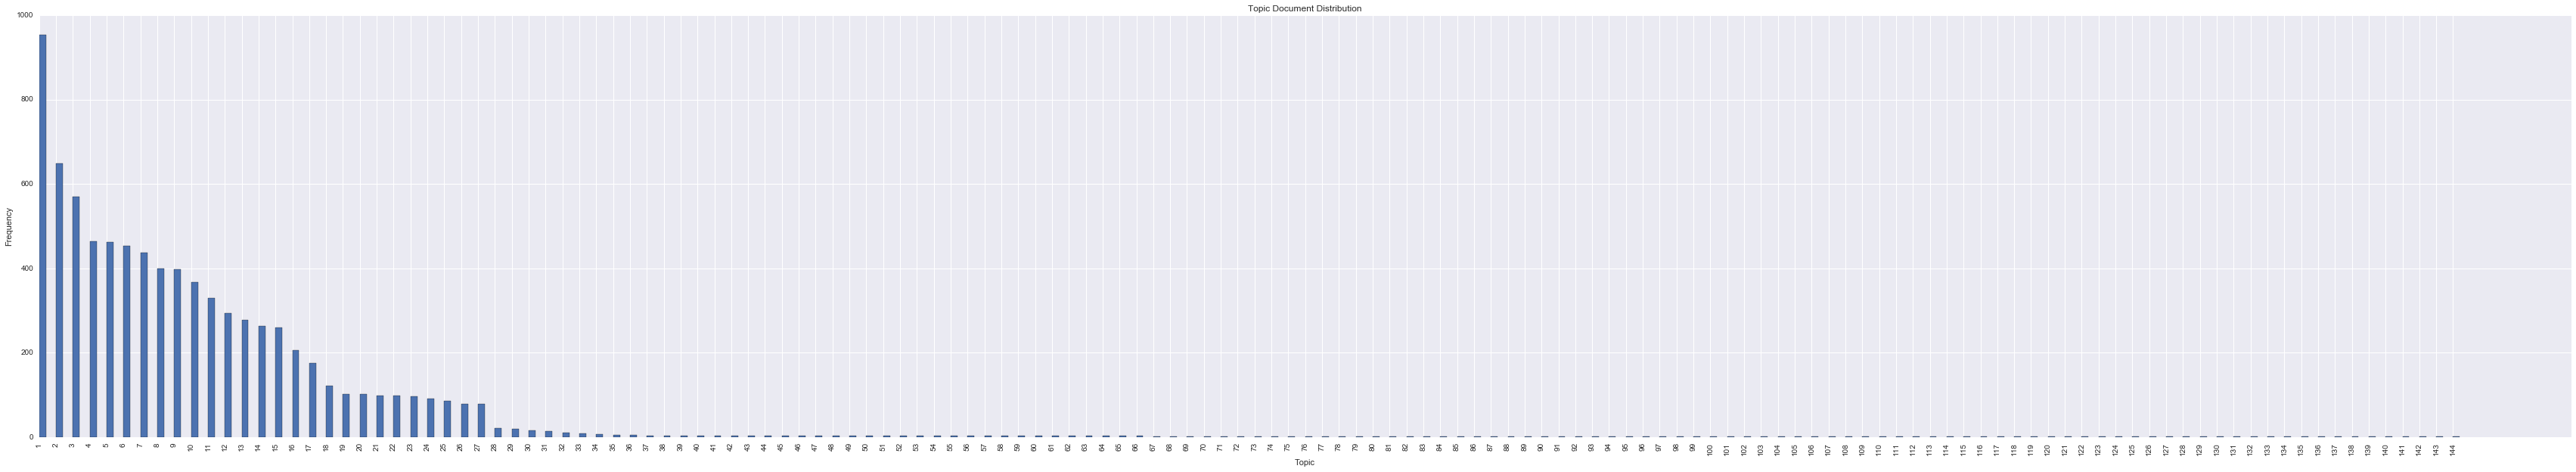

In [71]:
community_to_size_chart(net_topics)

In [72]:
import scipy.stats as stats

def topics_to_prob_dist(topics):
    x_data = []
    y_data = []
    for key, value in topics.items():
        x_data.append(key)
        y_data.append(len(value))

    df = pd.DataFrame(y_data)
    # df.hist(weights=np.ones_like(df[df.columns[0]]*100.)/len(df))

    plt.hist(df, log=True, weights=np.ones_like(df[df.columns[0]]*100.)/len(df))
    plt.xlabel("Topic Size")
    plt.ylabel("Probability")

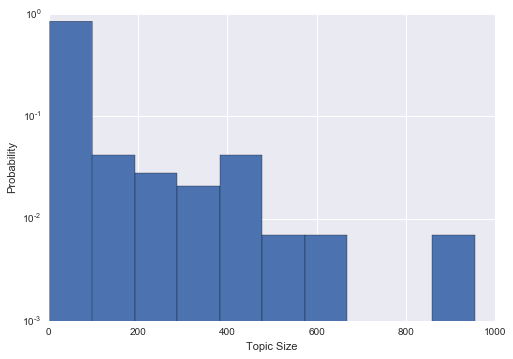

In [73]:
topics_to_prob_dist(net_topics)

In [232]:
topics = {}

for k, vs in net_topics.items():
    topics[k] = []
    for v in vs:
        topics[k].append(docs[v]['tfidf'])

intra_cluster_overall_similarity(topics)

0.50881158575407015

In [141]:
labels_true = {}

for k, vs in net_topics.items():
    labels_true[k] = []
    for v in vs:
        labels_true[k].append(docs[v]['section_id'])

In [142]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(topics)))
print("Weighted Similarity {0:.3f}".format(intra_cluster_weighted_similarity(topics)))
print("Inter Cluster Overall Similarity Top {0:.3f}".format(inter_cluster_overall_similarity(topics)))
print("Purity {0:.3f}".format(purity_weighted_score(len(labels_true.keys()), labels_true)))
print("Entropy {0:.3f}".format(entropy_weighted_score(len(labels_true.keys()), labels_true)))

Overall Similarity 0.509
Weighted Similarity 0.099
Inter Cluster Overall Similarity Top 0.075
Purity 0.460
Entropy 0.593


In [143]:
print("Intra")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= i})), end=",")

print("\nInter")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(inter_cluster_overall_similarity({k: v for k, v in topics.items() if k <= i})), end=",")
    
print("\nPurity")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(purity_weighted_score(i, labels_true)), end=",")

print("\nEntropy")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(entropy_weighted_score(i, labels_true)), end=",")

Intra
0.073,0.082,0.105,0.194,0.263,0.307,0.348,0.385,0.414,0.439,
Inter
0.555,0.464,0.364,0.264,0.204,0.171,0.146,0.126,0.111,0.100,
Purity
0.402,0.436,0.445,0.448,0.450,0.451,0.453,0.454,0.455,0.456,
Entropy
0.621,0.604,0.602,0.601,0.599,0.599,0.597,0.597,0.596,0.595,

In [233]:
sub_topics = {k: v for k, v in topics.items() if k <= 100}
topic_centroids = cluster_centroids(sub_topics)
matx_c = scipy.sparse.vstack((topic_centroids.values()))
matx_c_c = cosine_similarity(matx_c)
matx_c_c.shape

(100, 100)

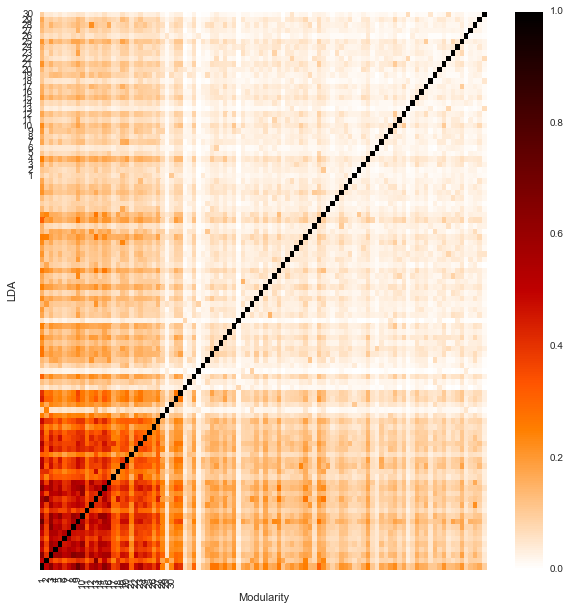

In [234]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns_plt = sns.heatmap(matx_c_c, cmap=plt.cm.gist_heat_r)
sns_plt.set(xticklabels=np.arange(1,31), yticklabels=(-np.sort(-np.arange(1,31))))
sns_plt.invert_yaxis()
plt.xlabel("Modularity")
plt.ylabel("LDA")

In [200]:
g_c = ig.Graph()
for i in range(len(matx_c_c)):
    g_c.add_vertices(str(i+1))
    
print(g_c.vcount())

30


In [201]:
for i, vs in enumerate(matx_c_c):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(matx_c_c)))
    source = str(int(i + 1))
    edges = []
    for j, vs in enumerate(matx_c_c):
        target = str(int(j + 1))
        edges.append((source, target))
    g_c.add_edges(edges)
    
print(g_c.ecount())

0.9666666666666667
900


In [202]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
for i, vs in enumerate(matx_c_c):
    clear_output(wait=True)
    for j, v in enumerate(vs):          
        g_c.es[count]["weight"] = v
        count += 1
    print('{0}\r'.format(count))

900


In [203]:
g_c.simplify(multiple=True, loops=True, combine_edges="max")
print(g_c.ecount())

435


In [204]:
g_c.es[1]['weight']

0.74431783169454191

In [205]:
g_c.write_gml('tmp/ig_mod_cen.gml')

# LDA

In [42]:
from gensim import matutils
from gensim.models.ldamodel import LdaModel

In [66]:
from sklearn.feature_extraction.text import CountVectorizer

print("Processing Count")

vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
X_count = vectorizer.fit_transform(token_values)

print(X_count.shape)

Processing Count
(9095, 141438)


In [67]:
vocab = vectorizer.get_feature_names()

In [389]:
def data_to_folds(data, k):
  folds = []

  for i in range(k):
    fold = []
    for j in range(i, data.shape[0], k):
      fold.append(data[j])
    folds.append(np.random.permutation(fold))

  return folds

folds = data_to_folds(X_count, 3)

In [390]:
# Partition data to train and test sets
# return list train data, list of test data
def split_folds(folds, i):
  train = folds[:i] + folds[i+1:]
  train = [x for data in train for x in data] # Flatten
  train = scipy.sparse.vstack((train))
  test = scipy.sparse.vstack(folds[i])
  
  return train, test

## Run LDA

In [ ]:
np.random.seed(1234)

train_log_preps = []
test_log_preps = []
train_preps = []
test_preps = []

for i in range(len(folds)):
    print("Fold ", i)
    X_count_train, X_count_test = split_folds(folds, i)
    train_corpus = matutils.Sparse2Corpus(X_count_train.T)
    test_corpus = matutils.Sparse2Corpus(X_count_test.T)
    
    lda_model = LdaModel(train_corpus, 
                    num_topics=150,
                    passes=20,
                    id2word=dict([(i, s) for i, s in enumerate(vocab)]))
    
    train_log_prep_gensim = lda_model.log_perplexity(train_corpus)
    test_log_prep_gensim = lda_model.log_perplexity(test_corpus)
    train_preplexity_gensim = np.exp2(-train_log_prep_gensim)
    test_preplexity_gensim = np.exp2(-test_log_prep_gensim)
    
    train_log_preps.append(train_log_prep_gensim)
    test_log_preps.append(test_log_prep_gensim)
    train_preps.append(train_preplexity_gensim)
    test_preps.append(test_preplexity_gensim)

In [90]:
print(train_log_preps)
print(test_log_preps)
print(train_preps)
print(test_preps)

[-8.8960191269017717, -8.8865588821434915, -8.9008065033543406, -8.8982838233571133, -8.900094750325021]
[-15.386968467727415, -15.191163657128232, -15.370776569679075, -15.354896605239361, -15.257463092753596]
[476.39654065214143, 473.2828654896594, 477.9800200262984, 477.14495994789746, 477.7442669310982]
[42848.838212735274, 37410.708216197352, 42370.618550133811, 41906.796052348014, 39170.043031390553]


In [371]:
lda_model = LdaModel(matutils.Sparse2Corpus(X_count.T), 
                num_topics=25,
                passes=50,
                id2word=dict([(i, s) for i, s in enumerate(vocab)]))

In [372]:
pickle.dump(lda_model, open('tmp/gensim_lda_25_50.pickle', 'wb'))

## Load LDA

In [277]:
lda_model = pickle.load(open('tmp/gensim_lda_100_50.pickle', 'rb'))

In [373]:
doc_topic_prob_mat = lda_model[matutils.Sparse2Corpus(X_count.T)]
print(len(doc_topic_prob_mat))

9095


In [374]:
for i, mat in enumerate(doc_topic_prob_mat):
    print('{0}\r'.format(i/len(doc_topic_prob_mat)))
    clear_output(wait=True)
    max_prob = max(mat, key=lambda x: x[1])
    docs[token_keys[i]]['lda'] = max_prob[0]
    docs[token_keys[i]]['lda_value'] = max_prob[1]

0.999890049477735


In [235]:
pickle.dump(docs, open('tmp/docs_lda_50_50.pickle', 'wb'))

In [43]:
docs = pickle.load(open('tmp/docs_lda_150_50.pickle', 'rb'))

In [44]:
lda_items = sorted(docs.items(), key=lambda x: x[1]['lda'])

In [45]:
d = list(map(lambda x: x[1]['lda_value'], docs.items()))

In [46]:
d_avg = np.average(d)
d_avg

0.31881381487607885

In [47]:
sum(1 for x in d if x >= 0.1)

9093

In [379]:
with open('tmp/lda_docs.txt', 'w+') as file:
    for item in lda_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['lda'], item[0], item[1]['webTitle']))

# LDA Size Chart

In [48]:
def lda_to_topics(lda_items, threshold):
    topics = {}

    for item in lda_items:
        topic_no = item[1]['lda']
        try:
            topics[topic_no]
        except:
            topics[topic_no] = []
            
        if item[1]['lda_value'] >= threshold:
            topics[topic_no].append(item[0])

    lda_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        if len(value) > 0:
            lda_topics[count] = value
        count += 1
        
    return lda_topics

In [49]:
def lda_to_size_chart(lda_topics):
    print(len(lda_topics.keys()))

    x_data = []
    y_data = []
    for key, value in lda_topics.items():
        x_data.append(key)
        y_data.append(len(value))

    ind = np.arange(0, len(y_data) * 2, 2)
    fig = plt.figure(figsize=(60,10))
    plt.bar(ind, y_data)
    plt.xticks(ind, x_data, rotation=90)
    plt.title("LDA Topic Document Distribution")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    fig.savefig('tmp/size_chart_lda.png')
    plt.show()

In [78]:
lda_items = sorted(docs.items(), key=lambda x: x[1]['lda'])
lda_topics = lda_to_topics(lda_items, 0.175)

In [79]:
count = 0
nodes = 0
for k, vs in lda_topics.items():
    if len(vs) > 0:
        count += 1
        nodes += len(vs)
print(count)
print(nodes)

140
8260


In [80]:
for key, value in lda_topics.items():
    for v in value:
        docs[v]['lda_topic'] = key
docs['2016-05-20-284'].keys()

dict_keys(['tfidf', 'guardianId', 'id', 'lda_value', 'lda_topic', 'webUrl', 'body', 'tags', 'webTitle', 'top_tfidf', 'apiUrl', 'authors', 'section_id', 'lda', 'webPublicationDate', 'mod_topic', 'sectionId', 'keyword'])

140


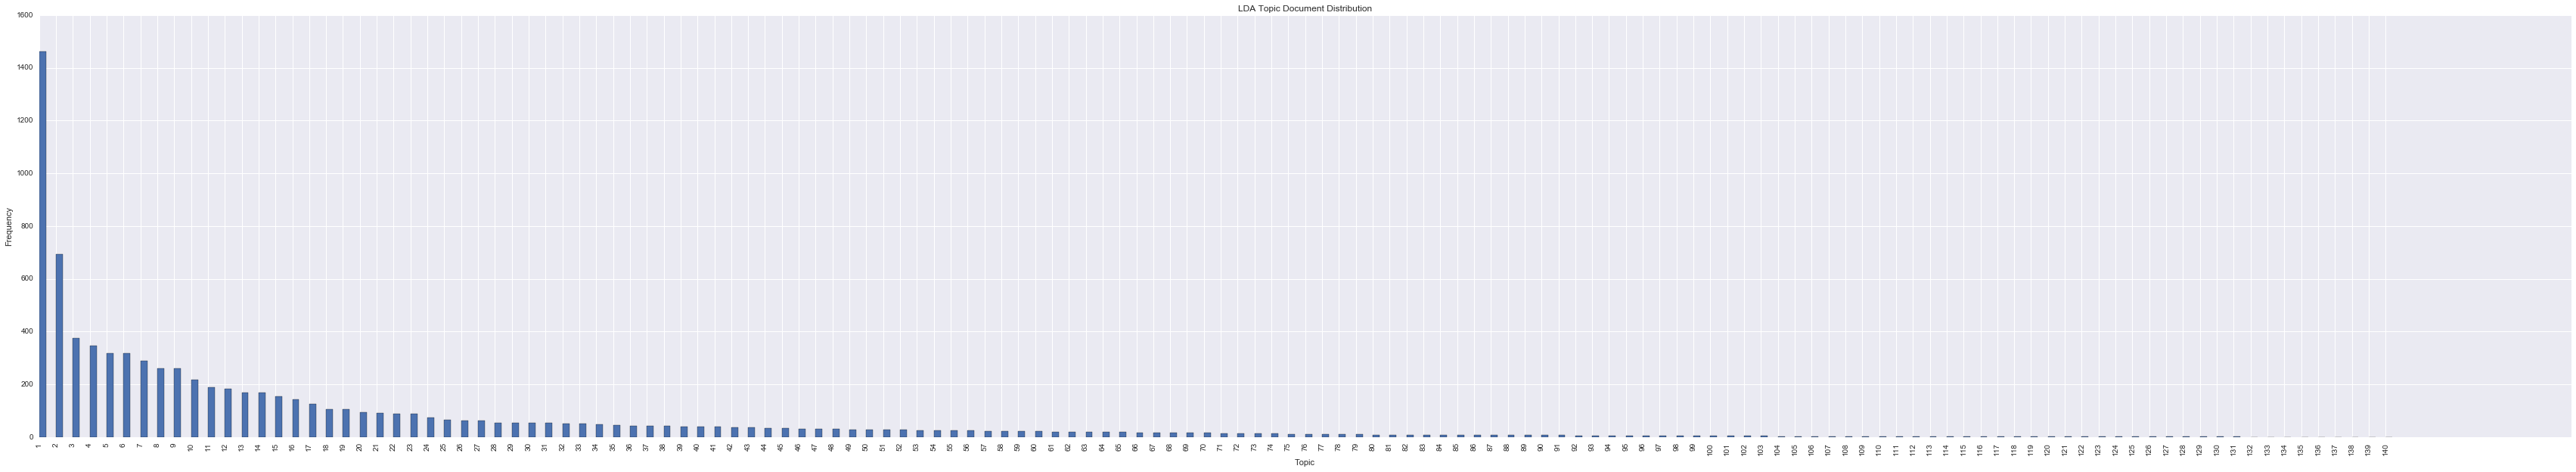

In [81]:
lda_to_size_chart(lda_topics)

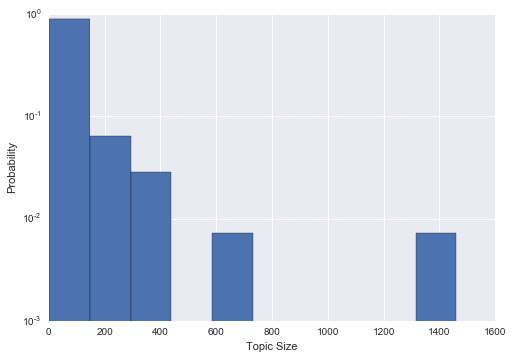

In [82]:
topics_to_prob_dist(lda_topics)

In [236]:
topics = {}

for k, vs in lda_topics.items():
    topics[k] = []
    for v in vs:
        topics[k].append(docs[v]['tfidf'])

In [227]:
labels_true = {}

for k, vs in lda_topics.items():
    labels_true[k] = []
    for v in vs:
        labels_true[k].append(docs[v]['section_id'])

In [228]:
intra_cluster_similarity(topics[1])

0.051755820502384212

In [229]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(topics)))
print("Weighted Similarity {0:.3f}".format(intra_cluster_weighted_similarity(topics)))
print("Inter Cluster {0:.3f}".format(inter_cluster_overall_similarity(topics)))
print("Purity {0:.3f}".format(purity_weighted_score(len(labels_true.keys()), labels_true)))
print("Entropy {0:.3f}".format(entropy_weighted_score(len(labels_true.keys()), labels_true)))

Overall Similarity 0.313
Weighted Similarity 0.111
Inter Cluster 0.116
Purity 0.462
Entropy 0.624


In [87]:
print("Intra")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= i})), end=",")

print("\nInter")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(inter_cluster_overall_similarity({k: v for k, v in topics.items() if k <= i})), end=",")
    
print("\nPurity")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(purity_weighted_score(i, labels_true)), end=",")

print("\nEntropy")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(entropy_weighted_score(i, labels_true)), end=",")

Intra
0.083,0.096,0.101,0.113,0.131,0.147,0.162,0.173,0.183,0.203,
Inter
0.540,0.430,0.364,0.321,0.285,0.256,0.229,0.203,0.184,0.170,
Purity
0.340,0.410,0.429,0.441,0.445,0.452,0.455,0.458,0.460,0.460,
Entropy
0.663,0.625,0.618,0.614,0.619,0.618,0.621,0.620,0.622,0.624,

In [237]:
sub_topics = {k: v for k, v in topics.items() if k <= 100}
topic_centroids = cluster_centroids(sub_topics)
matx_c = scipy.sparse.vstack((topic_centroids.values()))
matx_c_c = cosine_similarity(matx_c)
matx_c_c.shape

(100, 100)

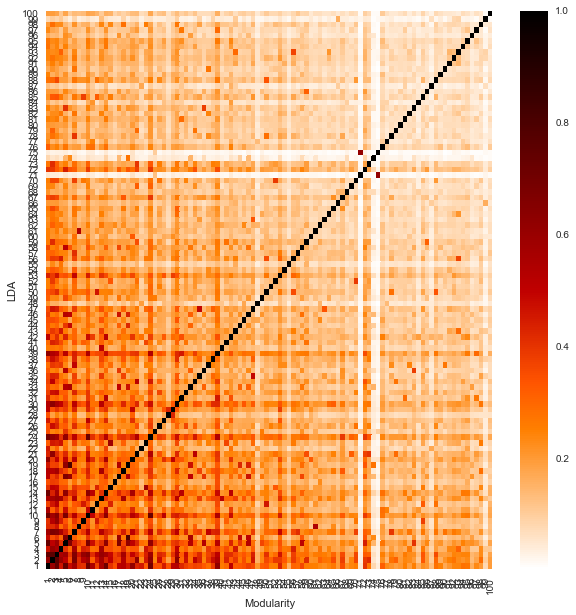

In [238]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns_plt = sns.heatmap(matx_c_c, cmap=plt.cm.gist_heat_r)
sns_plt.set(xticklabels=np.arange(1,101), yticklabels=(-np.sort(-np.arange(1,101))))
sns_plt.invert_yaxis()
plt.xlabel("Modularity")
plt.ylabel("LDA")

# Heatmap

In [95]:
def community_to_heatmap_data(network_topics):
    d = []
    for key, value in sorted(network_topics.items(), key=lambda x: x[0]):
        h = {}
        for v in value:
            h[v] = True
        d.append(h)

    return(d)

In [96]:
def lda_topics_to_heatmap_data(lda_topics):
    d = []
    for key, value in sorted(lda_topics.items(), key=lambda x: x[0]):
        h = {}
        for v in value:
            h[v] = True
        d.append(h)
        
    return d

In [97]:
net_data = community_to_heatmap_data(net_topics)
# lcm_data = community_to_heatmap_data(lcm_topics)
lda_data = lda_topics_to_heatmap_data(lda_topics)

In [134]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
vectors  = lda_data + net_data 
X_dict = vectorizer.fit_transform(vectors)

print(X_dict.shape)

(284, 8961)


In [135]:
print(len(lda_data[0].keys()))
print(len(lda_data))
print(len(net_data[0].keys()))
print(len(net_data))
print(np.count_nonzero(X_dict[0].toarray()))

1461
140
954
144
1461


In [136]:
lda_vectors = X_dict[0:140]
net_vectors = X_dict[140:]

In [137]:
from sklearn.metrics.pairwise import cosine_similarity

sub_sims = cosine_similarity(X_dict[0:30], X_dict[140:170])
sub_sims.shape

(30, 30)

In [138]:
def filter_max_in_sims(sims):
    sims = sims.copy()
    for sim in sims:
        low_values_indices = sim < np.amax(sim)
        sim[low_values_indices] = 0 
    return sims

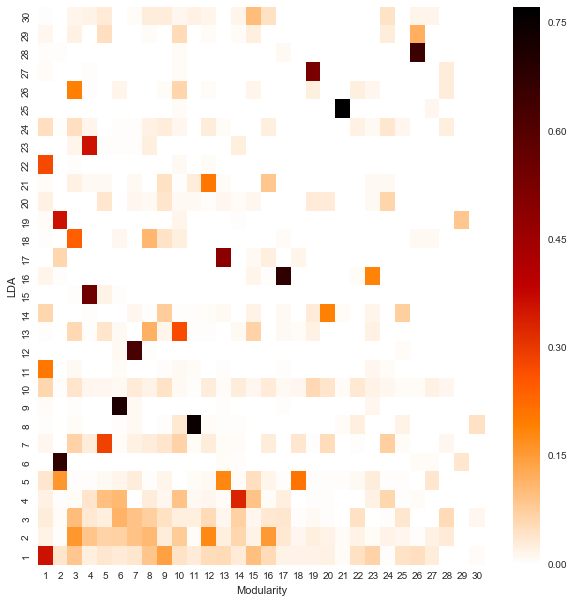

In [139]:
import seaborn as sns

filtered_sims = sub_sims
fig, ax = plt.subplots(figsize=(10, 10))
sns_plt = sns.heatmap(filtered_sims, cmap=plt.cm.gist_heat_r)
sns_plt.set(xticklabels=np.arange(1,31), yticklabels=(-np.sort(-np.arange(1,31))))
sns_plt.invert_yaxis()
plt.xlabel("Modularity")
plt.ylabel("LDA")

# Size to topic table + keywords

In [241]:
import itertools

def keywords_to_keyword_table(topics, n):
    result = {}
    for topic in topics:
        items = list(map(lambda x: x.values.tolist(), topic[1]))
        keywords = sorted(list(itertools.chain(*items)), key=lambda x: x[1], reverse=True)
        keywords = list(map(lambda x: x[0], keywords))
        keywords2 = sorted(set(keywords),key=keywords.index)[:n]
        result[topic[0]] = (len(topic[1]), keywords2)
    return result

In [242]:
def topics_to_keywords(topics):
    results = {}

    for k, vs in topics.items():
        results[k] = []
        for v in vs:
            results[k].append(docs[v]['keywords'])

    results = sorted(results.items(), key=lambda x: len(x[1]), reverse=True)
    
    return results

In [243]:
lda_keywords = keywords_to_keyword_table(topics_to_keywords(lda_topics), 50)

KeyError: 'keywords'

In [244]:
net_keywords = keywords_to_keyword_table(topics_to_keywords(net_topics), 50)

KeyError: 'keywords'

In [981]:
# lcm_keywords = keywords_to_keyword_table(topics_to_keywords(lcm_topics), 50)

In [982]:
set(lda_keywords[1][1]) & set(net_keywords[1][1])

{'antonia', 'cunk', 'eavi', 'hellboy', 'ipod', 'wed'}

In [942]:
import csv

sorted_1 = sorted(lda_keywords.items(), key=lambda x: x[1][0], reverse=True)
sorted_2 = sorted(net_keywords.items(), key=lambda x: x[1][0], reverse=True)

rows = []
for i in range(len(net_keywords)):
    row = [i+1]
    row += [sorted_1[i][1][0], sorted_2[i][1][0], sorted_1[i][1][1], sorted_2[i][1][1]]    
    rows.append(row)

with open('tmp/keywords.csv', 'w+') as file:    
    for row in rows:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(row)

In [992]:
similarities = pickle.load(open('tmp/similarities_mod_lcm.pickle', 'rb'))

In [993]:
a = similarities[6]
m = max(range(len(a)), key=lambda x: a[x])
m

23

In [994]:
import csv

rows = []
for i, row in enumerate(similarities):
    sim =  np.amax(row)
    net =  max(range(len(row)), key=lambda x: row[x]) + 1
    lda = i + 1
    rows.append([lda, net_keywords[lda][0], net, lcm_keywords[net][0], set(net_keywords[lda][1]) & set(lcm_keywords[net][1]), sim])

with open('tmp/matching.csv', 'w+') as file:    
    for row in sorted(rows, key=lambda x: x[1], reverse=True):
        writer = csv.writer(file, delimiter=';')
        writer.writerow(row)

# LCM

In [283]:
lda_model.minimum_probability=0.0

mat_lda = []
for i, m in enumerate(doc_topic_prob_mat):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(token_keys)))
    a = []
    for n in m:
        if n[1] >= 0.01:
            a.append(n[1])
        else:
            a.append(0)
    mat_lda.append(a)

0.9998899405679067


In [284]:
mat_lda = np.mat(mat_lda)
pickle.dump(mat_lda, open('tmp/mat.pickle', 'wb'))
mat_lda[1]

matrix([[ 0.        ,  0.11856003,  0.        ,  0.        ,  0.        ,
          0.02403184,  0.10266708,  0.        ,  0.03900642,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.02798356,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.0366805 ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.11155131,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.01927168,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.02307031,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.01359342,  0.        ,  0.        ,  0.01692062,
          0.        ,  0.        ,  0.

## Add LDA to docs

In [285]:
for i, key in enumerate(token_keys):
    docs[key]['lda_matrix'] = scipy.sparse.csr_matrix(mat_lda[i])
  
docs['2016-05-20-28']['lda_matrix']

<1x150 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [286]:
g_lcm = ig.Graph()
for i, key in enumerate(token_keys):
    g_lcm.add_vertices(key)
    
print(g_lcm.vcount())

9086


In [287]:
g_lcm.delete_edges(g.es)
edges = []
for i, source in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    for i_2, target in enumerate(token_keys):
        edges.append((source, target))
    clear_output(wait=True)
            
g_lcm.add_edges(edges)  
edges = [] 
print(g_lcm.ecount())

82555396


In [295]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
for i, source in enumerate(token_keys):
    clear_output(wait=True)
    similarities = cosine_similarity(mat_lda[i], mat_lda)[0]
    print('{0}\r'.format(i/len(token_keys)))
    for j, target in enumerate(token_keys):  
        g_lcm.es[count]["weight"] = similarities[j]
        count += 1

print(g_lcm.ecount())

0.9998899405679067
82555396


In [296]:
g_lcm.simplify(multiple=True, loops=True, combine_edges="max")
print(g_lcm.ecount())

41273155


In [303]:
sg_lcm = g_lcm.es.select(weight_ge=0.1).subgraph()

In [304]:
print("Nodes {}".format(sg_lcm.vcount()))
print("Edges {}".format(sg_lcm.ecount()))

Nodes 9086
Edges 23508092


In [124]:
sg_lcm.write_gml('tmp/igraph_lcm_8245.gml')

## Load LCM Network

In [ ]:
lda_sim = cosine_similarity(mat_lda, mat_lda)

In [310]:
g_lcm = ig.Graph.Read_GML('tmp/igraph_lcm_01.gml')

In [311]:
sg_lcm = g_lcm.es.select(weight_ge=0.8).subgraph() #0.8245

In [312]:
print("Nodes {}".format(sg_lcm.vcount()))
print("Edges {}".format(sg_lcm.ecount()))

Nodes 8216
Edges 259465


In [313]:
# community = sg.community_infomap(edge_weights='weight')
community_lcm = sg_lcm.community_multilevel(weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

In [314]:
network_properties(sg_lcm, community_lcm)

Nodes 8216
Edges 259465
Diameter 17
LCC 7931
APL 5.400419346676614
AD 63.160905550146055
Giant Size 989
NO of Communities 113
Modularity 0.8088135748871019


In [315]:
lcm_topics = network_to_topics(community_lcm)

In [316]:
for key, value in lcm_topics.items():
    for v in value:
        docs[v]['lcm_topic'] = key

docs['2016-05-20-284'].keys()

dict_keys(['lda_matrix', 'webUrl', 'hclust', 'webTitle', 'webPublicationDate', 'tfidf', 'guardianId', 'body_t', 'section_id', 'keywords', 'apiUrl', 'body', 'lcm_topic', 'ents', 'km', 'id', 'lda_value', 'mod_topic', 'sectionId', 'lda_topic', 'lda', 'authors'])

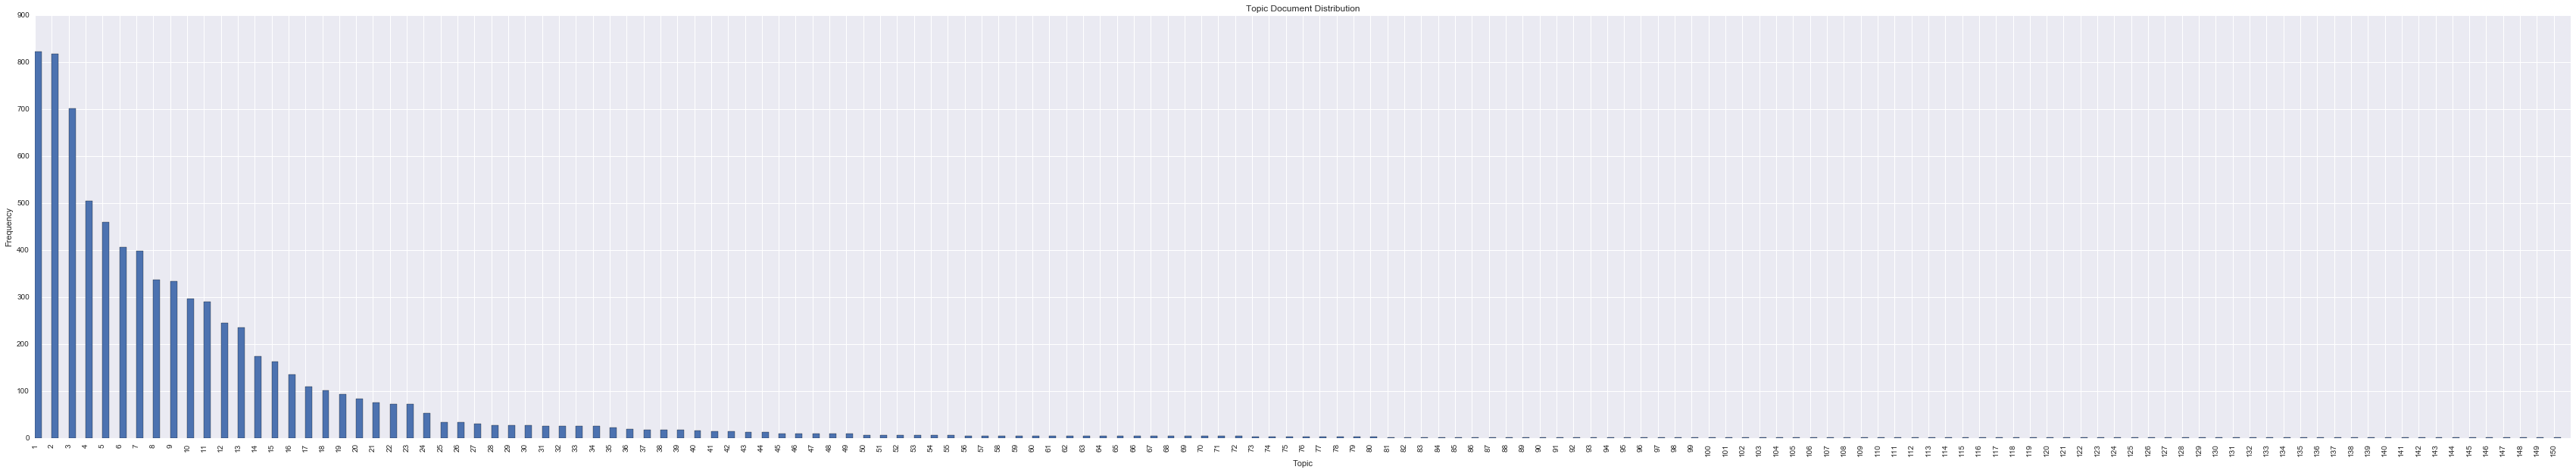

In [56]:
community_to_size_chart(lcm_topics)

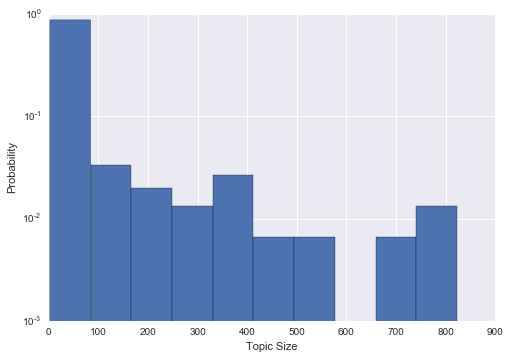

In [394]:
topics_to_prob_dist(lcm_topics)

In [ ]:
with open('tmp/lcm_docs.txt', 'w+') as file:
    for i in range(max(community_lda.membership) + 1):
        for v in community_lda.subgraph(i).vs():
            file.write("Topic:{} File:{} Title:{}\n".format(i, v['name'], docs[v['name']]['webTitle']))

In [320]:
topics = {}

for k, vs in lcm_topics.items():
    topics[k] = []
    for v in vs:
        topics[k].append(docs[v]['tfidf'])

intra_cluster_weighted_similarity(topics)

0.10123731721106291

In [321]:
print("Overall Similarity Top 10 {}", intra_cluster_weighted_similarity({k: v for k, v in topics.items() if k <= 10}))
print("Overall Similarity Top 30 {}", intra_cluster_weighted_similarity({k: v for k, v in topics.items() if k <= 30}))
print("Overall Similarity Top 100 {}", intra_cluster_weighted_similarity({k: v for k, v in topics.items() if k <= 100}))

Overall Similarity Top 10 {} 0.0677972891515
Overall Similarity Top 30 {} 0.0827357690271
Overall Similarity Top 100 {} 0.0993775615203


## LDA network

In [273]:
g_lda = g_lcm.es.select(weight_ge=0.5).subgraph()
print("Nodes {}".format(g_lda.vcount()))
print("Edges {}".format(g_lda.ecount()))

Nodes 9086
Edges 2823445


In [274]:
lda_topics_values = [val for sublist in list(lda_topics.values()) for val in sublist]
len(lda_topics_values)

7452

In [275]:
to_delete_ids = [v.index for v in g_lda.vs if v['name'] not in lda_topics_values] 
len(to_delete_ids)

1634

In [276]:
g_lda.delete_vertices(to_delete_ids)
print("Nodes {}".format(g_lda.vcount()))
print("Edges {}".format(g_lda.ecount()))

Nodes 7452
Edges 1902342


In [334]:
sg_lda = g_lda.es.select(weight_ge=0.7).subgraph()
print("Nodes {}".format(sg_lda.vcount()))
print("Edges {}".format(sg_lda.ecount()))

Nodes 7406
Edges 610745


In [335]:
for v in sg_lda.vs:
    v['Community'] = docs[v['name']]['lda_sorted']
sg_lda.vs[0]

igraph.Vertex(<igraph.Graph object at 0x1188159a8>, 0, {'Community': 2, 'name': '2016-05-04-301', 'id': 0.0})

In [336]:
membership = []
for v in sg_lda.vs():
    membership.append(v['Community'])

In [337]:
print("LDA Communities Modularity {}".format(sg_lda.modularity(membership)))

LDA Communities Modularity 0.6869776895329


In [338]:
sg_lda.write_gml('tmp/igraph_lda_8.gml')

# Hierarchical Clustering

In [13]:
from scipy.cluster.hierarchy import dendrogram

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(X_tfidf)

In [15]:
X_tfidf.toarray()[:3]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.11202137,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

dist2 = pairwise_distances(X_tfidf, metric="cosine")

In [19]:
from scipy.cluster.hierarchy import average

In [20]:
len(dist2)

9086

In [21]:
print("Start Hierarchical Clustering...")

linkage_matrix = average(dist2) #define the linkage_matrix using hierachical clustering pre-computed distances

print("Done Hierarchical Clustering...")

Start Hierarchical Clustering...
Done Hierarchical Clustering...


In [22]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(linkage_matrix, pdist(dist2))
c

0.75992263482351696

In [23]:
pickle.dump(linkage_matrix, open('tmp/linkage_matrix_average_l1.pickle', 'wb'))

In [24]:
pickle.dump(dist2, open('tmp/dist_l1.pickle', 'wb'))

In [339]:
linkage_matrix = pickle.load(open('tmp/linkage_matrix_average.pickle', 'rb'))

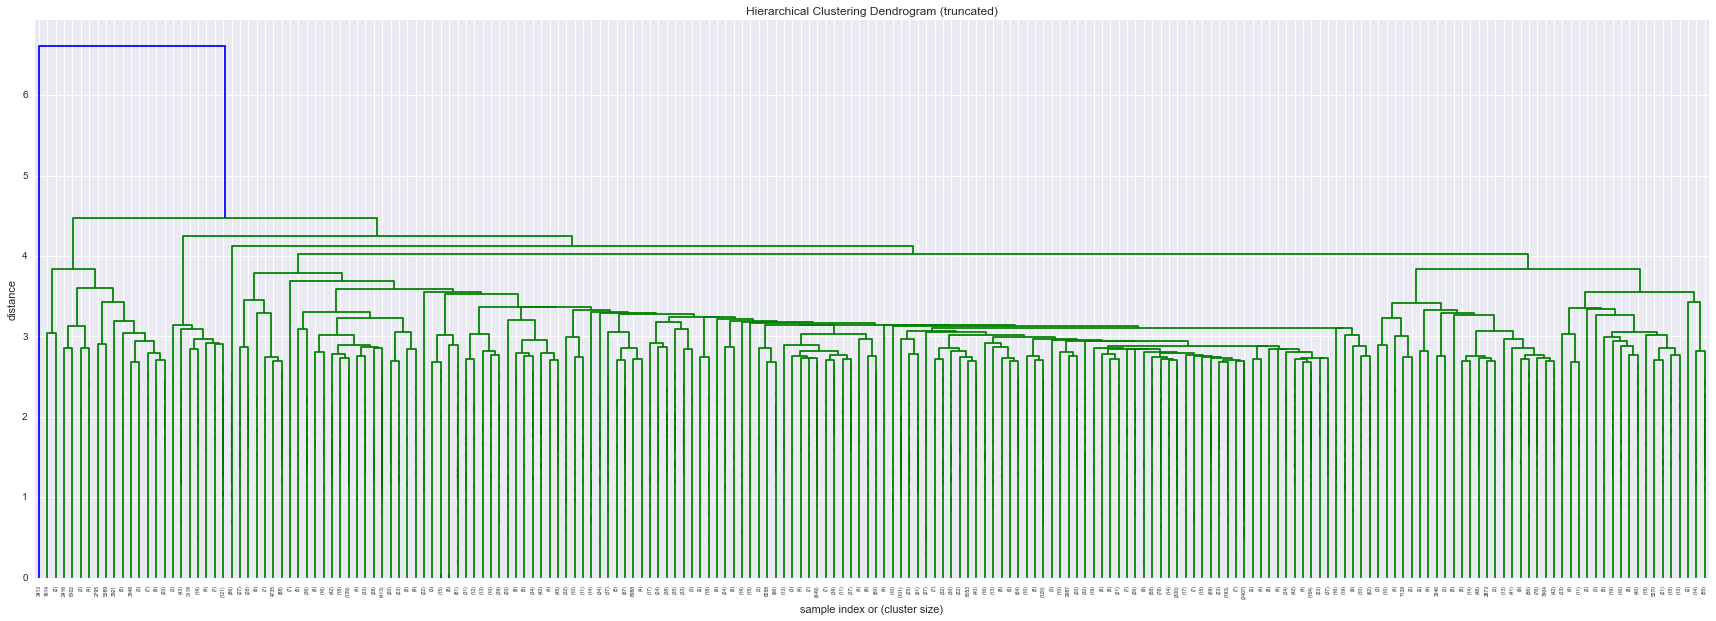

In [15]:
plt.figure(figsize=(30, 10))
fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=200,
    leaf_rotation=90.,
    leaf_font_size=5.,
    show_contracted=True,
    annotate_above=200,  # useful in small plots so annotations don't overlap
)
plt.show()

In [351]:
from scipy.cluster.hierarchy import fclusterdata, fcluster

def cluster_indices(cluster_assignments):
    n = cluster_assignments.max()
    indices = []
    for cluster_number in range(1, n + 1):
        indices.append(np.where(cluster_assignments == cluster_number)[0])
    return indices

# Compute the clusters.
cluster_assignments = fcluster(linkage_matrix, 2, criterion="distance")

# Print the indices of the data points in each cluster.
num_clusters = cluster_assignments.max()
print("%d clusters" % num_clusters)
indices = cluster_indices(cluster_assignments)

print("Giant Size:", len(max(indices, key=lambda x: len(x))))

# for k, ind in enumerate(indices):
#     print("cluster", k + 1, " (Length:)", len(ind), "=", ind)

for k, ind in enumerate(indices):
    for i in ind:
        docs[token_keys[i]]['hclust'] = k

2272 clusters
Giant Size: 406


In [342]:
hclust_items = sorted(docs.items(), key=lambda x: x[1]['hclust'])

In [343]:
with open('tmp/hclust_docs.txt', 'w+') as file:
    for item in hclust_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['hclust'], item[0], item[1]['webTitle']))

In [352]:
topics = {}

for i in range(num_clusters):
    topics[i] = []
    
for item in hclust_items:
    topic_no = item[1]['hclust']
    topics[topic_no].append(item[0])
    
print(len(topics.keys()))

hclust_topics = {}
count = 1
for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
    hclust_topics[count] = value
    count += 1

2272


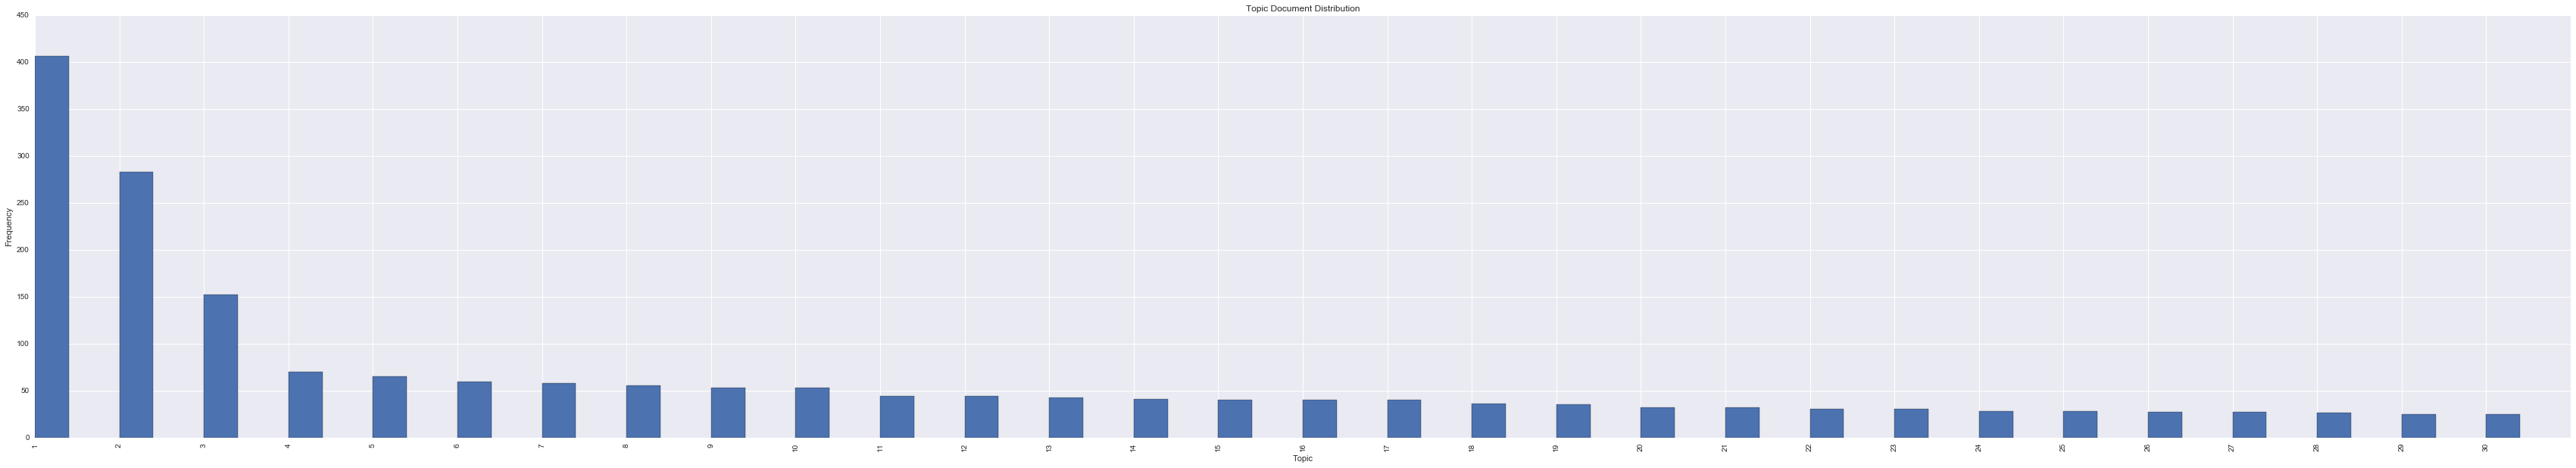

In [353]:
x_data = []
y_data = []
for key, value in sorted(hclust_topics.items(), key=lambda x: len(x[1]), reverse=True):
    if key <= 30:
        x_data.append(key)
        y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(60,10))
plt.bar(ind, y_data)
plt.xticks(ind, x_data, rotation=90)
plt.title("Topic Document Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
fig.savefig('tmp/size_chart_lda.png')
plt.show()

In [354]:
topics = {}

for k, vs in hclust_topics.items():
    topics[k] = []
    for v in vs:
        topics[k].append(docs[v]['tfidf'])

In [355]:
print("Overall Similarity", intra_cluster_weighted_similarity(topics))
print("Overall Similarity Top 10 {}", intra_cluster_weighted_similarity({k: v for k, v in topics.items() if k <= 10}))
print("Overall Similarity Top 30 {}", intra_cluster_weighted_similarity({k: v for k, v in topics.items() if k <= 30}))
print("Overall Similarity Top 150 {}", intra_cluster_weighted_similarity({k: v for k, v in topics.items() if k <= 200}))

Overall Similarity 0.274490618109
Overall Similarity Top 10 {} 0.0408301617999
Overall Similarity Top 30 {} 0.0477840573944
Overall Similarity Top 150 {} 0.0810012267979


In [356]:
labels_true = {}

for k, vs in hclust_topics.items():
    labels_true[k] = []
    for v in vs:
        labels_true[k].append(docs[v]['section_id'])

In [357]:
print("Purity {0:.3f}".format(purity_weighted_score(len(labels_true.keys()), labels_true)))
print("Entropy {0:.3f}".format(entropy_weighted_score(len(labels_true.keys()), labels_true)))

Purity 0.326
Entropy 0.874


In [358]:
print("Purity {0:.3f}".format(purity_weighted_score(30, labels_true)))
print("Entropy {0:.3f}".format(entropy_weighted_score(30, labels_true)))

Purity 0.109
Entropy 0.923


# KMeans

In [453]:
from sklearn.cluster import KMeans

num_clusters = 400

km = KMeans(n_clusters=num_clusters)

%time km.fit(X_tfidf)

clusters = km.labels_.tolist()

CPU times: user 44min 3s, sys: 3min 1s, total: 47min 4s
Wall time: 47min 28s


In [454]:
for i, cluster in enumerate(clusters):
    print('{0}\r'.format(i/len(clusters)))
    clear_output(wait=True)
    docs[token_keys[i]]['km'] = cluster

0.9998899405679067


In [467]:
for k, v in docs.items():
    docs[k]['section_id'] = section_id[v['sectionId']]

In [457]:
pickle.dump(docs, open('tmp/docs_km400.pickle', 'wb'))

In [466]:
docs = pickle.load(open('tmp/docs_km500.pickle', 'rb'))

In [468]:
def km_to_topics(km_items):
    topics = {}

    for item in km_items:
        topic_no = item[1]['km']
        try:
            topics[topic_no]
        except:
            topics[topic_no] = []
        topics[topic_no].append(item[0])

    km_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        km_topics[count] = value
        count += 1

    return km_topics

In [469]:
km_items = sorted(docs.items(), key=lambda x: x[1]['km'])
km_topics = km_to_topics(km_items)

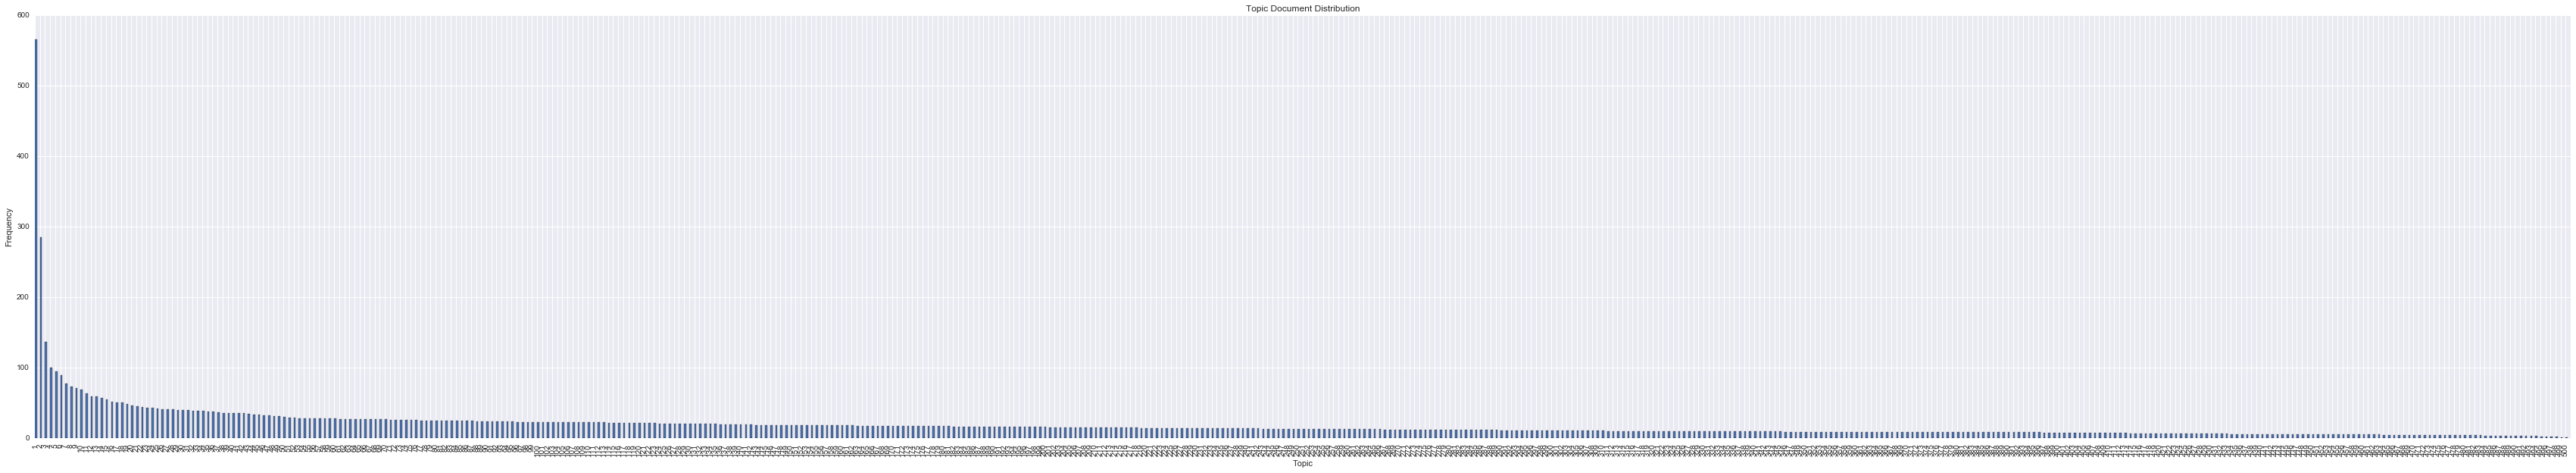

In [470]:
x_data = []
y_data = []
for key, value in sorted(km_topics.items(), key=lambda x: len(x[1]), reverse=True):
    x_data.append(key)
    y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(60,10))
plt.bar(ind, y_data)
plt.xticks(ind, x_data, rotation=90)
plt.title("Topic Document Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
fig.savefig('tmp/size_chart_lda.png')
plt.show()

In [471]:
topics = {}

for k, vs in km_topics.items():
    topics[k] = []
    for v in vs:
        topics[k].append(docs[v]['tfidf'])

In [472]:
print("Mean", intra_cluster_overall_similarity(topics))
print("Mean Similarity Top 10 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 10}))
print("Mean Similarity Top 30 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 30}))
print("Mean Similarity Top 100 {}", intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= 100}))

Mean 0.298180269465
Mean Similarity Top 10 {} 0.112116778398
Mean Similarity Top 30 {} 0.168110989909
Mean Similarity Top 100 {} 0.194713441404


In [473]:
inter_cluster_overall_similarity(topics)

0.11662039060434207

In [474]:
labels_true = {}

for k, vs in km_topics.items():
    labels_true[k] = []
    for v in vs:
        labels_true[k].append(docs[v]['section_id'])

In [475]:
print("Purity {0:.3f}".format(purity_weighted_score(len(labels_true.keys()), labels_true)))
print("Entropy {0:.3f}".format(entropy_weighted_score(len(labels_true.keys()), labels_true)))

Purity 0.583
Entropy 0.623


In [494]:
print("Intra")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(intra_cluster_overall_similarity({k: v for k, v in topics.items() if k <= i})), end=",")

print("\nInter")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(inter_cluster_overall_similarity({k: v for k, v in topics.items() if k <= i})), end=",")
    
print("\nPurity")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(purity_weighted_score(i, labels_true)), end=",")

print("\nEntropy")
for i in np.arange(10,101,10):
    print("{0:.3f}".format(entropy_weighted_score(i, labels_true)), end=",")

Intra
0.112,0.152,0.168,0.180,0.188,0.199,0.196,0.197,0.198,0.195,
Inter
0.457,0.335,0.303,0.277,0.253,0.232,0.221,0.212,0.207,0.202,
Purity
0.354,0.452,0.479,0.485,0.499,0.513,0.517,0.524,0.533,0.535,
Entropy
0.689,0.628,0.620,0.622,0.619,0.609,0.613,0.611,0.603,0.606,

# Visualization

In [31]:
def add_community_to_graph(key, graph, com):
    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            node = graph.vs().find(name=v['name'])
            node['Community'] = docs[v['name']][key]

## LDA Graph

In [390]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(lda_vectors, net_vectors)

matching = {}
for i, a in enumerate(similarities):
    b =  max(range(len(a)), key=lambda x: a[x])
    matching[i] = b

print(matching)

{0: 0, 1: 8, 2: 4, 3: 10, 4: 14, 5: 13, 6: 32, 7: 17, 8: 26, 9: 1, 10: 18, 11: 39, 12: 22, 13: 21, 14: 36, 15: 20, 16: 42, 17: 25, 18: 6, 19: 29, 20: 23, 21: 11, 22: 30, 23: 1, 24: 23, 25: 31, 26: 40, 27: 0, 28: 11, 29: 9, 30: 39, 31: 15, 32: 0, 33: 2, 34: 3, 35: 0, 36: 20, 37: 3, 38: 20, 39: 0, 40: 0, 41: 0, 42: 9, 43: 25, 44: 24, 45: 0, 46: 3, 47: 3, 48: 0, 49: 0}


In [ ]:
for v in sg_lda.vs:
    v['Community'] = docs[v['name']]['lda_sorted']
sg_lda.vs[0]

In [ ]:
membership = []
for v in sg_lda.vs():
    membership.append(v['Community'])

In [ ]:
print("LDA Communities Modularity {}".format(sg_lda.modularity(membership)))

In [ ]:
for v in sg_lda.vs:
    v['Community'] = matching[v['Community']]

In [ ]:
sg_lda.vs[0]

In [ ]:
sg_lda.write_gml('tmp/lda_community.gml')